In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Read dataset from web into R

In [3]:
url <- "https://raw.githubusercontent.com/dvolman/DSCI-Group-Project/main/Raisin_Dataset.csv"
raisin_data <- read_csv(url)
raisin_data

Rows: 900 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Class
dbl (7): Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
99657,431.7070,298.8373,0.7216841,106264,0.7410985,1292.828,Besni
93523,476.3441,254.1761,0.8457385,97653,0.6587983,1258.548,Besni
85609,512.0818,215.2720,0.9073454,89197,0.6320200,1272.862,Besni


Since we are treating `Class` as a categorical variable, we convert it into a factor. We also rename column names for readability.

In [4]:
raisin_data <- raisin_data |>
                mutate(Class = as_factor(Class))
colnames(raisin_data) <- c("Area", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent", "Perimeter", "Class")
raisin_data

Area,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
99657,431.7070,298.8373,0.7216841,106264,0.7410985,1292.828,Besni
93523,476.3441,254.1761,0.8457385,97653,0.6587983,1258.548,Besni
85609,512.0818,215.2720,0.9073454,89197,0.6320200,1272.862,Besni


Splitting data into training set and testing set.

In [6]:
set.seed(5)

raisin_split <- initial_split(raisin_data, prop = 0.75, strata = Class)
raisin_train <- training(raisin_split)
raisin_test <- testing(raisin_split)
raisin_train
raisin_test

Area,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
137583,649.5415,273.2603,0.9072011,142650,0.7316377,1590.354,Besni
117592,533.2929,288.5583,0.8409660,123587,0.7300677,1432.006,Besni
95546,487.1783,251.9602,0.8558749,99166,0.7227820,1276.807,Besni
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
67874,360.0235,243.2720,0.7371662,69889,0.6783194,1035.277,Kecimen
50312,354.2356,182.3121,0.8573923,52070,0.6233522,961.439,Kecimen
41995,259.2089,210.3508,0.5843375,43443,0.7297006,801.526,Kecimen


Area,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
94282,494.1630,244.8039,0.8686701,97707,0.7023862,1269.680,Besni
68799,356.5678,253.2547,0.7039427,71879,0.7009292,1041.270,Besni
93523,476.3441,254.1761,0.8457385,97653,0.6587983,1258.548,Besni


Summarize number of observations for each class as a percentage of total observations. Confirm there are no missing data. 

In [7]:
missing_data <- any(is.na(raisin_train))
total_obs <- nrow(raisin_data) 
summary <- raisin_data |>
            group_by(Class) |>
            summarize(count = n(), percentage = n() / total_obs * 100, missing_data = missing_data)
summary

Class,count,percentage,missing_data
<fct>,<int>,<dbl>,<lgl>
Kecimen,450,50,FALSE
Besni,450,50,FALSE


Mean values of predictors we will be using. 

In [8]:
mean_predictors <- raisin_data |>
                summarize(mean_Area = mean(Area),
                         mean_Major_Axis_Length = mean(Major_Axis_Length),
                         mean_Convex_Area = mean(Convex_Area),
                         mean_Perimeter = mean(Perimeter))
mean_predictors

mean_Area,mean_Major_Axis_Length,mean_Convex_Area,mean_Perimeter
<dbl>,<dbl>,<dbl>,<dbl>
87804.13,430.93,91186.09,1165.907


Distribution of each class in the predictors we are using. 

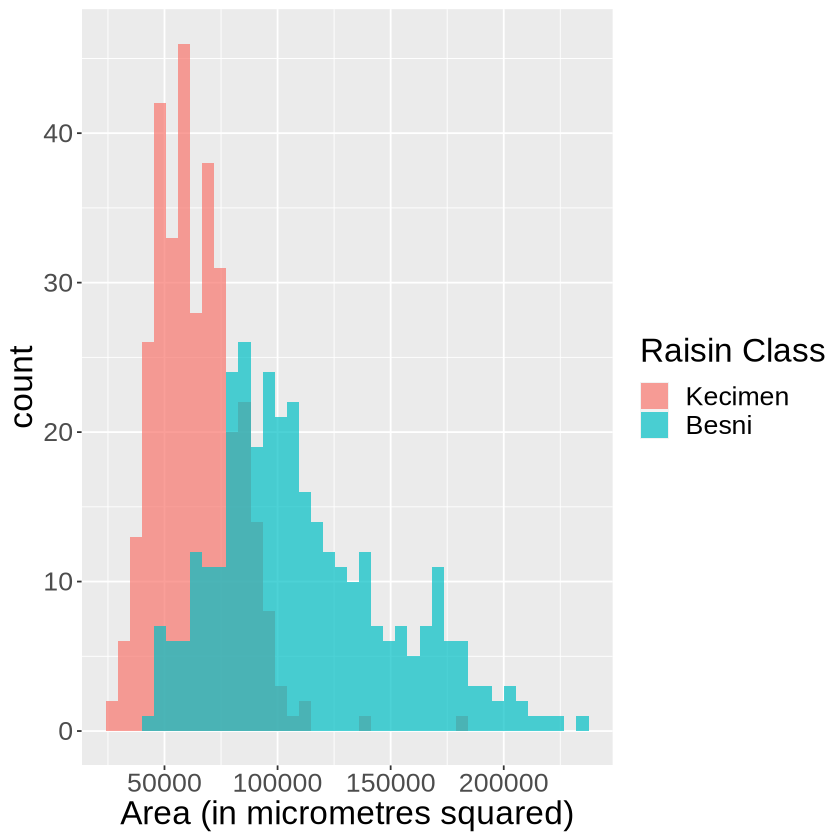

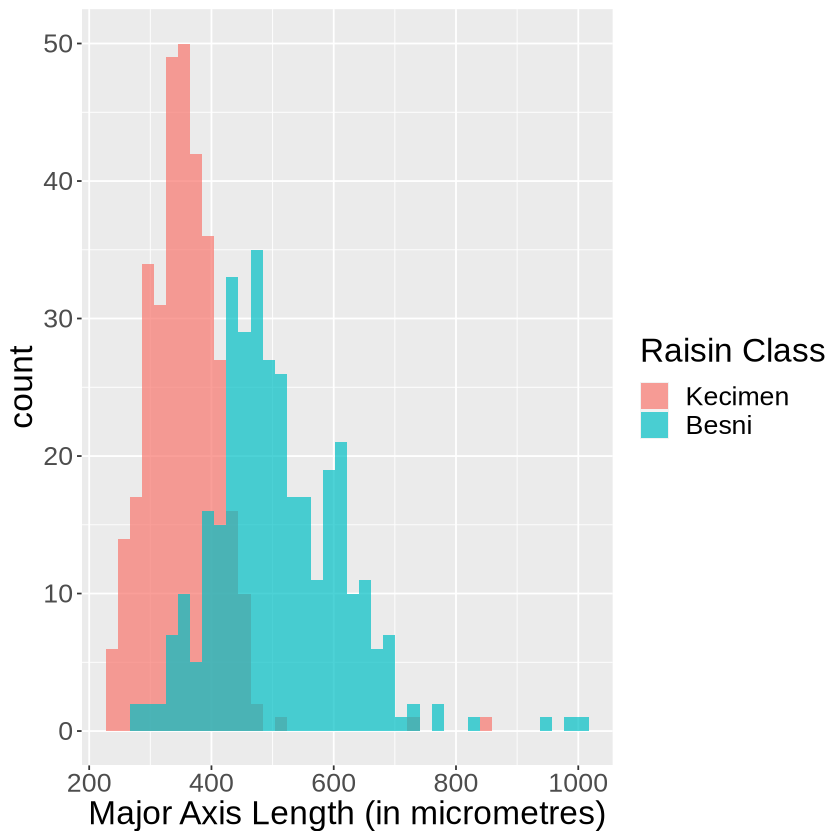

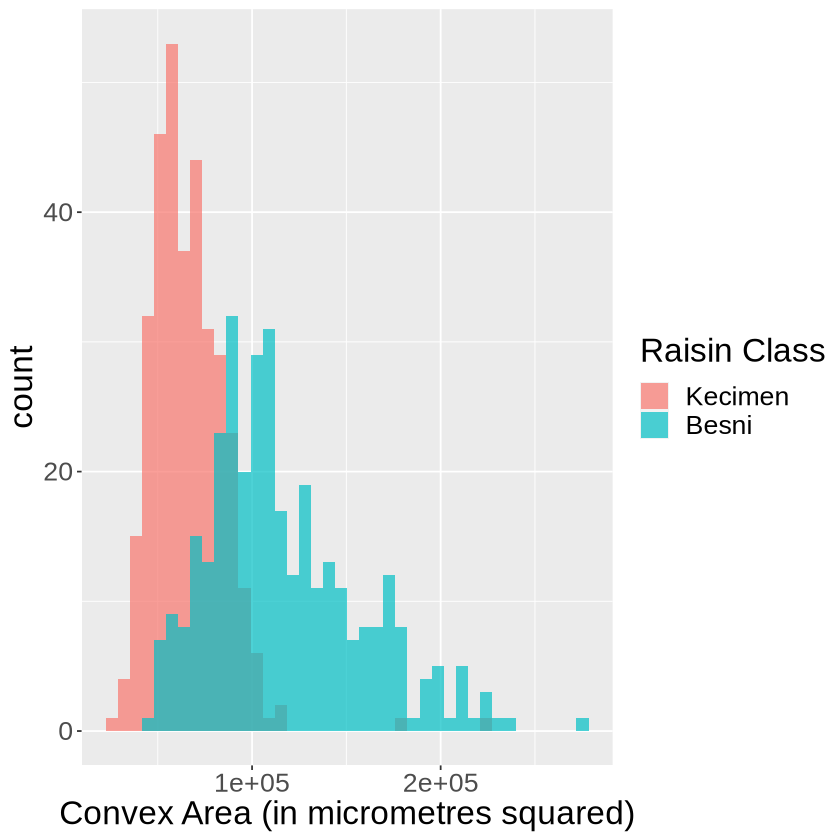

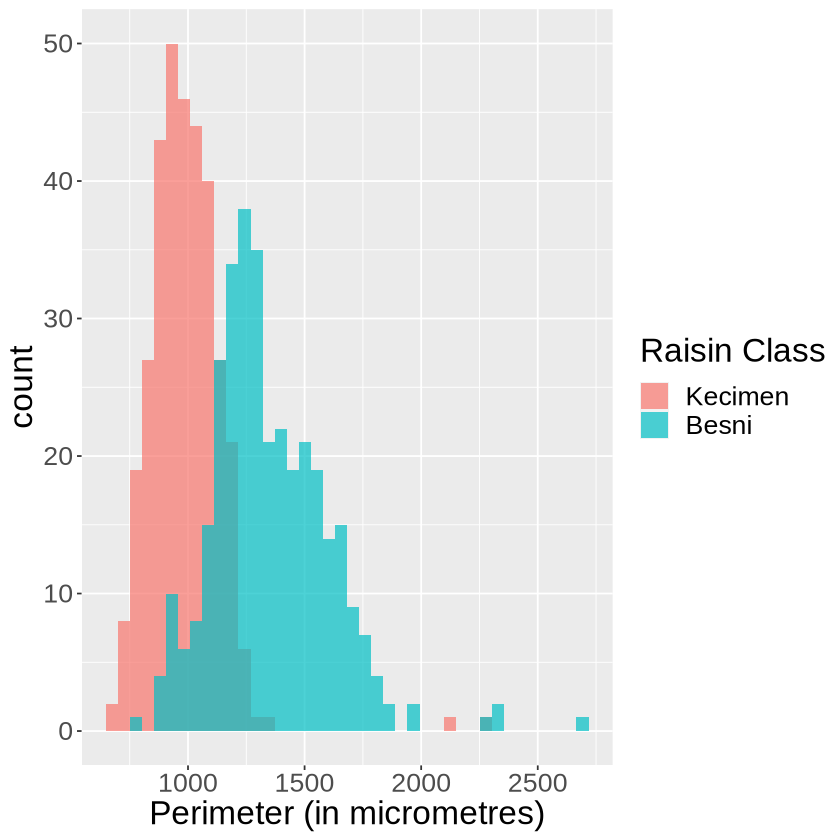

In [29]:
hist_Area <- raisin_train |>
                    ggplot(aes(x = Area, fill = Class)) +
                    geom_histogram(position = "identity", alpha = 0.7, bins = 40) +
                    labs(x = "Area (in micrometres squared)", fill = "Raisin Class") +
                    theme(text = element_text(size = 20))
hist_Major_Axis_Length <- raisin_train |>
                    ggplot(aes(x = Major_Axis_Length, fill = Class)) +
                    geom_histogram(position = "identity", alpha = 0.7, bins = 40) +
                    labs(x = "Major Axis Length (in micrometres)", fill = "Raisin Class") +
                    theme(text = element_text(size = 20))
hist_Convex_Area <- raisin_train |>
                    ggplot(aes(x = Convex_Area, fill = Class)) +
                    geom_histogram(position = "identity", alpha = 0.7, bins = 40) +
                    labs(x = "Convex Area (in micrometres squared)", fill = "Raisin Class") +
                    theme(text = element_text(size = 20))
hist_Perimeter <- raisin_train |>
                    ggplot(aes(x = Perimeter, fill = Class)) +
                    geom_histogram(position = "identity", alpha = 0.7, bins = 40) +
                    labs(x = "Perimeter (in micrometres)", fill = "Raisin Class") +
                    theme(text = element_text(size = 20))
hist_Area
hist_Major_Axis_Length
hist_Convex_Area
hist_Perimeter